# Import and node definition

In [1]:
import numpy as np
from pyiron_workflow import Workflow, to_function_node, as_function_node
from pyiron_workflow.api import inputs_to_dict
from python_workflow_definition.pyiron_base import write_workflow_json

In [2]:
from workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [3]:
@as_function_node
def get_values_from_dict(input_dict):
    return list(input_dict.values())

In [4]:
workflow_json_filename = "pyiron_workflow_qe.json"

In [5]:
calculate_qe = to_function_node("calculate_qe", _calculate_qe, "calculate_qe")
generate_structures = to_function_node("generate_structures", _generate_structures, "generate_structures")
get_bulk_structure = to_function_node("get_bulk_structure", _get_bulk_structure, "get_bulk_structure")
plot_energy_volume_curve = to_function_node("plot_energy_volume_curve", _plot_energy_volume_curve, "plot_energy_volume_curve", validate_output_labels=False)

# Build the structure 
Everything works as expected. 

In [6]:
wf = Workflow("my_workflow")

In [7]:
wf.pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [8]:
wf.element = "Al"
wf.a = 4.04
wf.cubic = True
wf.structure = get_bulk_structure(
    element=wf.element,
    a=wf.a,
    cubic=wf.cubic,
)

# Setting up the first Quantum ESPRESSO simulation
The use of the inputs_to_dict() function is not clear: https://github.com/pyiron/pyiron_workflow/issues/648

In [9]:
wf.working_directory_0 = "mini"
input_dict = {
    "structure": wf.structure, 
    "pseudopotentials": wf.pseudopotentials, 
    "kpts": (3, 3, 3), 
    "calculation": "vc-relax", 
    "smearing": 0.02,
}
wf.input_dict_0 = inputs_to_dict(
    input_specification=list(input_dict.keys()),
    **input_dict
)

In [10]:
wf.calc_mini = calculate_qe(
    working_directory=wf.working_directory_0,
    input_dict=wf.input_dict_0,
)

# Strain the relaxed structure 

In [11]:
number_of_strains = 5
wf.strain_lst = np.linspace(0.9, 1.1, number_of_strains)
wf.structure_lst = generate_structures(  # the generate_structures() function is not available in the workflow graph
    structure=wf.calc_mini["structure"],
    strain_lst=wf.strain_lst,
)

# Static calculation for each strained structure
When accessing the strained structure for the first time, the initial structure optimization is executed even though this is not intended. 

In [12]:
job_strain_lst = []
for i in range(number_of_strains):
    setattr(wf, "input_dict_" + str(i+1), inputs_to_dict(
        input_specification=["structure", "pseudopotentials", "kpts", "calculation", "smearing"],
        structure=wf.structure_lst["s_" + str(i)],
        pseudopotentials=wf.pseudopotentials,
        kpts=(3, 3, 3),
        calculation="scf",
        smearing=0.02,
    ))
    setattr(wf, "calc_strain_" + str(i), calculate_qe(
        working_directory="strain_" + str(i),
        input_dict=getattr(wf, "input_dict_" + str(i+1)),
    ))
    job_strain_lst.append(getattr(wf, "calc_strain_" + str(i)))

# Collect results
Again the corresponding calculations get executed during the inputs_to_dict() stage.

In [13]:
volume_dict = {"s_" + str(i): j["volume"] for i, j in enumerate(job_strain_lst)}
wf.volume_dict = inputs_to_dict(
    input_specification=list(volume_dict.keys()),
    **volume_dict
)
energy_dict = {"s_" + str(i): j["energy"] for i, j in enumerate(job_strain_lst)}
wf.energy_dict = inputs_to_dict(
    input_specification=list(energy_dict.keys()),
    **energy_dict,
)
wf.volume_lst = get_values_from_dict(
    input_dict=wf.volume_dict
)
wf.energy_lst = get_values_from_dict(
    input_dict=wf.energy_dict
)

# Plot results

In [14]:
wf.plot = plot_energy_volume_curve(volume_lst=wf.volume_lst, energy_lst=wf.energy_lst)

# Visualize Workflow

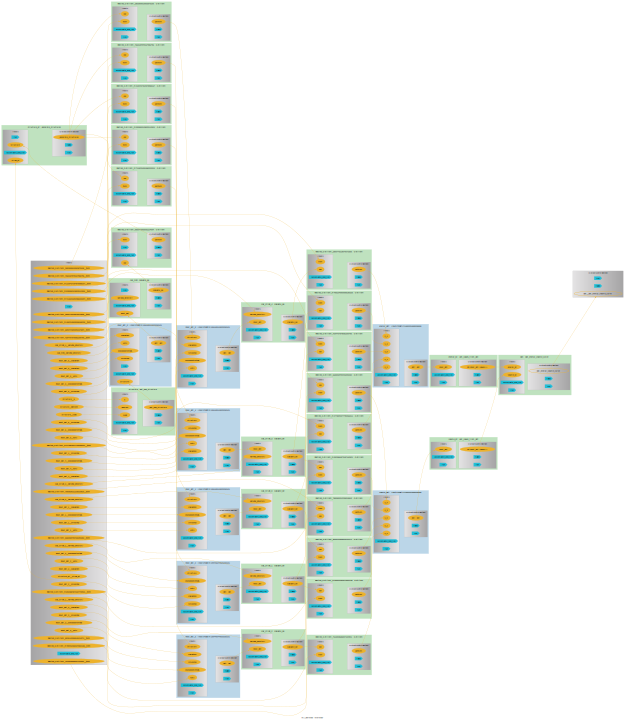

In [15]:
wf.draw(size=(10,10))

# Final execution

[jupyter-pythonworkflow-fl--x---120ada5c:01031] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---120ada5c:01057] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---120ada5c:01068] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---120ada5c:01086] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: 

{'plot__plot_energy_volume_curve': None}

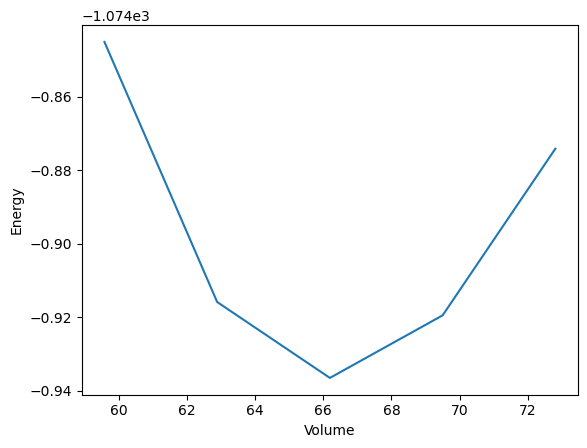

In [16]:
wf.run()